In [1]:
from sklearn.decomposition import PCA
import xarray as xr
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

In [2]:
# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-40, 40.),
        'lat' : (65, 85),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 15.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [3]:
## Function to crop the dataset
def Crops(coord, d_set, dictionary):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by a dictionary.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
            
        dictionary: dic
            name of the dictionary wwith the coordinates
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """

    lon1, lon2 = dictionary[coord]['lon']
    lat1, lat2 = dictionary[coord]['lat']
    name_fig = dictionary[coord]['name']

    return(d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2)))



def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)


def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)


def Normalize(data_set):
    mn = data_set.min(dim='week', skipna=True)
    mx = data_set.max(dim='week', skipna=True)
    
    y = (data_set - mn) / (mx - mn)
    return y


def Re_arrange(data_set, years):
    g = []

    for i,y in enumerate(years):
        aa = data_set.sel(time=data_set['year']==y)
        aa = aa.stack(map=('longitude', 'latitude'))
        aa = aa.groupby('time.week').mean(dim='time', skipna=True)
        
        aa = aa.reset_index(dims_or_levels='map')
        aa = aa.sel(week=slice(1,52))
        
        g.append(aa)
        del aa

    return(g)



def Shift(data_set):
    max_w = data_set.groupby('map').argmax(dim='week', keep_attrs=True, skipna=True).values
    r = 26 - max_w 
    
    data = data_set.T.values
    del data_set
    
    rows, column_indices = np.ogrid[:data.shape[0], :data.shape[1]]
    r[r < 0] += data.shape[1]
    column_indices = column_indices - r[:, np.newaxis]
    shft = data[rows, column_indices]
    shift = xr.DataArray(shft.T, dims=['week', 'map'], name='mlotst')

    return(shift)

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################
dir_1 = '../../New_ARMOR/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_of = '/home/lgarcia/Documents/Other_datasets/'
dir_oi = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

In [5]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

## Doing a version for a small area: Gulf Stream

Using 1/4 of the grid points.

In [64]:
coord = 'noa'
region = Crops(coord, c_armor1, reg_ext)
region2 = Crops(coord, c_armor15, reg_ext)

region2 = Masking(region2, region2.to[0,25])

In [65]:
points = region.mlotst[:,::4,::4].where(region2.mask==1)

print(points.latitude.size, points.longitude.size)

75 105


In [66]:
#del c_armor1, c_armor15, region2, region, weeks, d1, d2

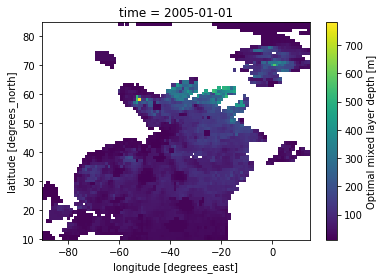

In [67]:
points[0].plot()

In [68]:
yr = points.time.dt.year
points.coords['year'] = (('time'), yr)

In [69]:
#del la, lo, valsla, valslo

## Re-shaping the dataset

It  is done in two groups. The analysis ignores the 2018 because is not complete. The shift is done to put the maximum at the meiddle of the year (at week 26).

In [70]:
## Exclude 2018 because is not a full year
years1 = [y for y in range(2005, 2018)]

In [71]:
## Reshaping, normalizing and shifting
new_points = Re_arrange(points, years1)

In [72]:
new_points = xr.concat(new_points, dim='map')
new_points= new_points.dropna(dim='map', how='any')


In [73]:
new_points = new_points.diff(dim='week', n=1)

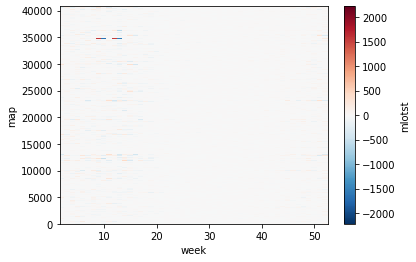

In [74]:
new_points.T.plot()

# PCA for the original dataset

## Seasonal cycle for some points in the region

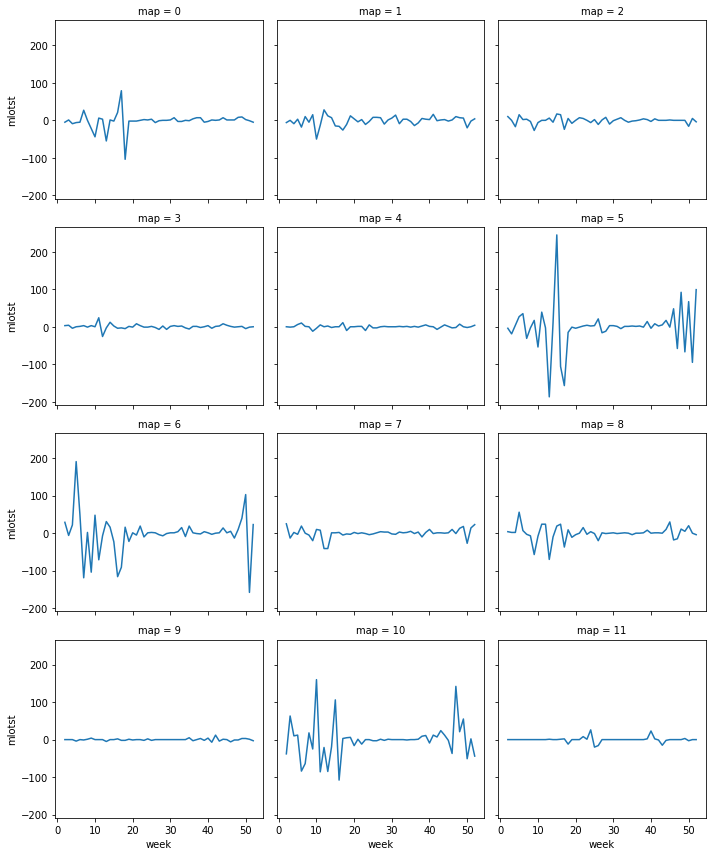

In [79]:
new_points[:,12000:13800:150].T.plot(col="map", col_wrap=3, hue='map')

In [80]:
# Run the PCA analysis:
n_components = 12  # Rq: n_components cannot exceed ncols !
pca = PCA(n_components=n_components)

# eigenvectors
pca = pca.fit(new_points.T)

In [81]:
# Loadings
pca.components_.shape

(12, 51)

In [82]:
print(pca.components_.size, pca.components_.shape)

612 (12, 51)


In [83]:
print(pca.singular_values_, pca.singular_values_.shape)

[23012.32883609 22230.2706909  19881.01714919 19214.1130085
 18006.81202436 15935.11354064 15072.48111112 14284.65544958
 13496.85743492 11890.73943079 11624.68914555 10741.17594502] (12,)


In [84]:
# Principal components :: make the projection 
reduced_values = pca.transform(new_points.T)
reduced_values.shape

(40801, 12)

In [85]:
# the shape is : (4550, 12)
reduced_values[0]

array([  2.41679795,   8.13516735,  -2.51447908,  -1.45936167,
         5.7891742 ,  -4.69827331,  -5.20161498,  -1.2615536 ,
       -10.13723006,   1.00613725,   1.25278793,  -2.33648702])

## Preparing a new data array with the results

In [86]:
samp = reduced_values.shape[0]
eof = reduced_values.shape[1]
w = new_points.week.size

data = np.zeros((samp,eof,w))

result = xr.DataArray(data, dims=['sample', 'prin_comp', 'week'], name="fake_data")

In [87]:
result['reduced_data'] = xr.DataArray(reduced_values, dims=['sample', 'prin_comp'])

result['loadings'] = xr.DataArray(pca.components_, dims=['prin_comp', 'week'], 
                                  attrs={'comment': 'Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.'})
result['explained_variance'] = xr.DataArray(pca.explained_variance_ratio_*100, 
                                        dims=['prin_comp'], attrs={'comment': 'Percentage of variance explained by each of the selected components'})

## Plotting the loadings

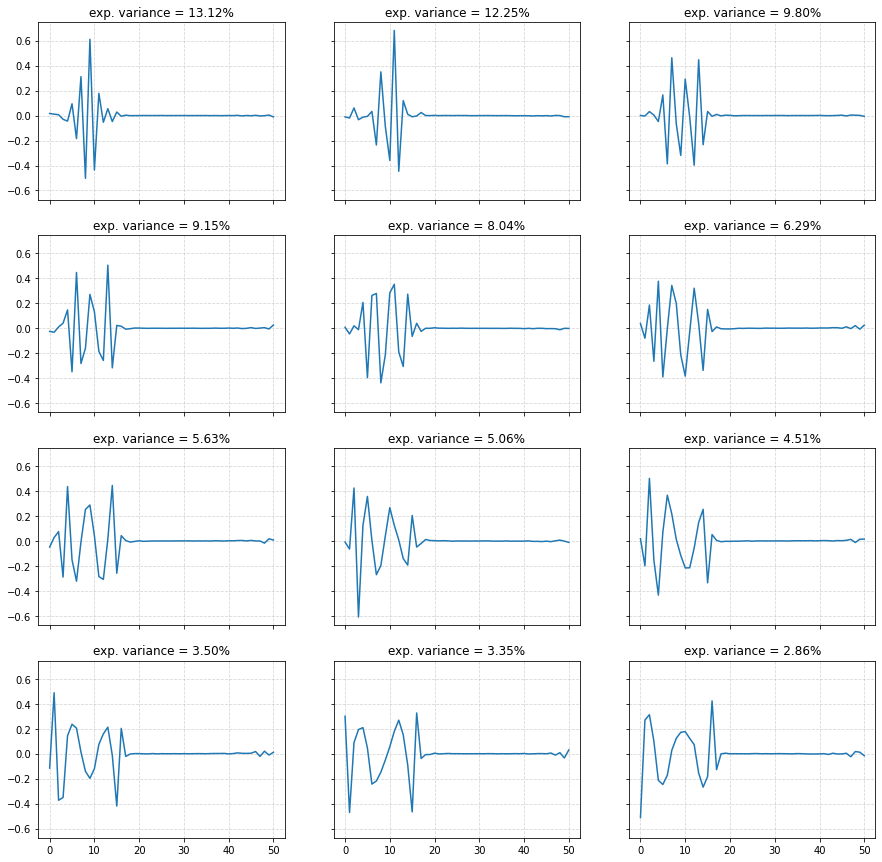

In [88]:
n_cols = 3
n_rows = 4

coeff = 0

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,15), sharex=True, sharey=True)

for i in range(n_rows):
    for j in range(n_cols):
        y = result['loadings'][coeff]

        ev = str('{:.2f}'.format(result['explained_variance'][coeff].values))
        name = 'exp. variance = ' + ev + '%'
        
        ax[i,j].plot(y) 
        ax[i,j].set_title(name)    
        ax[i,j].grid(linestyle='--', alpha=0.5)
        coeff += 1

plt.show()

## Explained variance of the eigenvalues

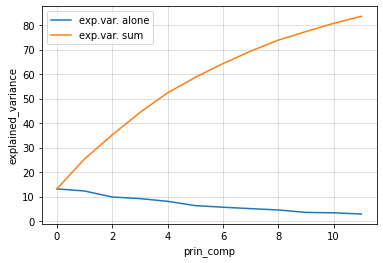

In [89]:
result['explained_variance'].plot(label='exp.var. alone')
result['explained_variance'].cumsum(dim='prin_comp').plot(label='exp.var. sum')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

## Plot of the data projected over the PC space

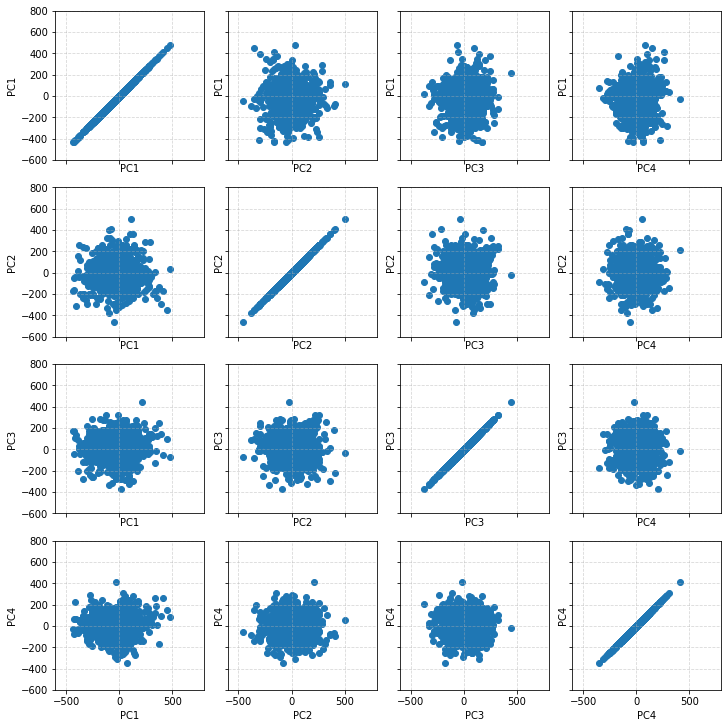

In [63]:
ncols = 4
nrows = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10), sharex=True, sharey=True, constrained_layout=True)

for i in range(nrows):
    for j in range(ncols):
        x = result['reduced_data'][:,j]#PC[j]
        y = result['reduced_data'][:,i]#PC[i]
        
        pc_x = 'PC' + str(j+1)
        pc_y = 'PC' + str(i+1)

        ax[i,j].scatter(x, y)

        ax[i,j].set_xlabel(pc_x)
        ax[i,j].set_ylabel(pc_y)
        ax[i,j].grid(linestyle='--', alpha=0.5)
        

plt.xlim(-600., 800)
plt.ylim(-600., 800)

plt.show()